In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

TRAIN_DATASET_PATHS = [
    PWD + '/data/dataset/dataset_r354332.pkl',
    PWD + '/data/dataset/dataset.pkl',
    PWD + '/data/dataset/dataset_r355445.pkl',
    PWD + '/data/dataset/dataset_r355558.pkl',
    PWD + '/data/dataset/dataset_r355680.pkl',
    PWD + '/data/dataset/dataset_r355769.pkl',
]

TEST_DATASET_PATH = PWD + '/data/dataset/dataset_r370138.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.05
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_r370138.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
train_datasets = []
for path in TRAIN_DATASET_PATHS:
    with open(path, 'rb') as file:
        train_datasets.append(pickle.load(file))

with open(TEST_DATASET_PATH, 'rb') as file:
    test_dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=6, es_patience=30, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_other_runs_r370138', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Load optimal CFD thresholds

In [8]:
# from src.cfd import find_optimal_cfd_threshold
#
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(test_dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = test_dataset[(plane, channel)][0], test_dataset[(plane, channel)][1]
#     # X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, all_X, all_y, X_TIME, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

Processing p=1, ch=2...
Optimal CFD threshold: 0.200
Processing p=1, ch=11...
Optimal CFD threshold: 0.140
Processing p=2, ch=2...
Optimal CFD threshold: 0.205
Processing p=2, ch=11...
Optimal CFD threshold: 0.120
Processing p=3, ch=2...
Optimal CFD threshold: 0.170
Processing p=3, ch=11...
Optimal CFD threshold: 0.120


In [9]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.200
(1, 11): 0.140
(2,  2): 0.205
(2, 11): 0.120
(3,  2): 0.170
(3, 11): 0.120


# Train the network

In [10]:
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
for dataset in train_datasets:
    for (plane, channel), (X, y) in dataset.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                            random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

        Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
        Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

        train_X_list.append(X_train)
        train_y_list.append(Y_heatmap_train)
        test_X_list.append(X_test)
        test_y_list.append(Y_heatmap_test)

X_train_all = np.concatenate(train_X_list)
y_train_all = np.concatenate(train_y_list)
X_test_all = np.concatenate(test_X_list)
y_test_all = np.concatenate(test_y_list)

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape

((324264, 24), (324264, 24), (81081, 24), (81081, 24))

In [12]:
model = optimal_model_builder_all_ch()
history = train_model(model, "optimal", X_train=X_train_all, y_train=y_train_all, X_val=X_test_all, y_val=y_test_all,
                      train=False, n_epochs=N_EPOCHS)

Epoch 1/1000
40/40 [==============================] - 21s 330ms/step - loss: 859.2668 - val_loss: 2523119747072.0000 - lr: 0.0500
Epoch 2/1000
40/40 [==============================] - 12s 292ms/step - loss: 99.9658 - val_loss: 1854.6221 - lr: 0.0500
Epoch 3/1000
40/40 [==============================] - 12s 294ms/step - loss: 55.3279 - val_loss: 67.8600 - lr: 0.0500
Epoch 4/1000
40/40 [==============================] - 12s 293ms/step - loss: 41.9230 - val_loss: 33.5836 - lr: 0.0500
Epoch 5/1000
40/40 [==============================] - 11s 282ms/step - loss: 34.5747 - val_loss: 36.8931 - lr: 0.0500
Epoch 6/1000
40/40 [==============================] - 11s 280ms/step - loss: 30.1828 - val_loss: 37.1604 - lr: 0.0500
Epoch 7/1000
40/40 [==============================] - 11s 281ms/step - loss: 27.7945 - val_loss: 34.3712 - lr: 0.0500
Epoch 8/1000
40/40 [==============================] - 11s 288ms/step - loss: 26.5682 - val_loss: 31.4681 - lr: 0.0500
Epoch 9/1000
40/40 [======================

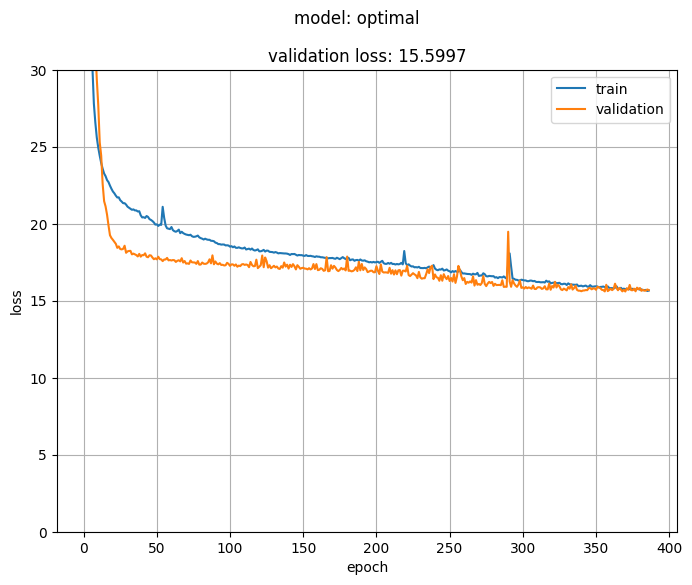

In [13]:
plot_history(history, f'model: optimal', ymax=30)

# Test

Processing p=1, ch=2...
1/1 [==============================] - 0s 14ms/step
       CFD: 78.47 ps
   optimal: 74.48 ps (improvement: 5.08 %)
Processing p=1, ch=11...
1/1 [==============================] - 0s 15ms/step
       CFD: 86.50 ps
   optimal: 137.36 ps (improvement: -58.79 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 17ms/step
       CFD: 92.08 ps
   optimal: 80.17 ps (improvement: 12.94 %)
Processing p=2, ch=11...
1/1 [==============================] - 0s 14ms/step
       CFD: 78.15 ps
   optimal: 100.43 ps (improvement: -28.52 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 15ms/step
       CFD: 77.57 ps
   optimal: 66.40 ps (improvement: 14.39 %)
Processing p=3, ch=11...
1/1 [==============================] - 0s 16ms/step
       CFD: 87.21 ps
   optimal: 105.55 ps (improvement: -21.03 %)


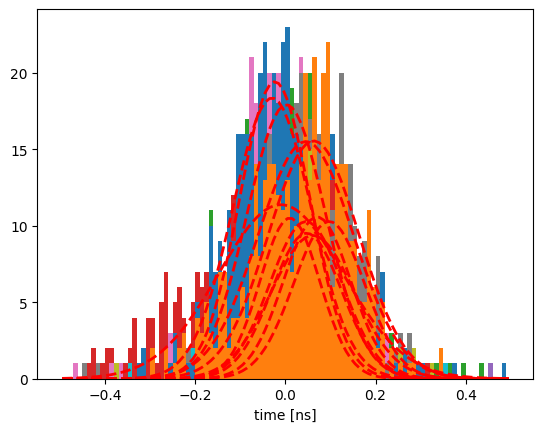

In [18]:
improvements = {}
for (plane, channel), (all_X, all_y) in test_dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [19]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  78.47 ps, NN:  74.48 ( 5.08 %)
(1, 11) CFD:  86.50 ps, NN: 137.36 (-58.79 %)
(2,  2) CFD:  92.08 ps, NN:  80.17 (12.94 %)
(2, 11) CFD:  78.15 ps, NN: 100.43 (-28.52 %)
(3,  2) CFD:  77.57 ps, NN:  66.40 (14.39 %)
(3, 11) CFD:  87.21 ps, NN: 105.55 (-21.03 %)
